# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

drive_path = 'drive/My Drive/Colab Notebooks/WP_Datasets_Normalized/'

dataset_train_1 = pd.read_csv(drive_path+'Dataset_Train_1_new.csv')
dataset_test_1 = pd.read_csv(drive_path+'Dataset_Test_1_new.csv')

dataset_train_1.head()

,Date_Time,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air_Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air_Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air_Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air_Density_150m,Park_Power_[KW]
0,2017-01-07 20:15:00,0.476323,0.110000,0.218502,0.782227,0.752212,0.473538,0.127679,0.218502,0.752212,0.484680,0.047716,0.218502,0.752212,0.515320,0.019504,0.218502,0.752212,0.690394
1,2017-01-07 20:30:00,0.479109,0.116923,0.214832,0.781496,0.755162,0.479109,0.135714,0.214832,0.755162,0.473538,0.053299,0.214832,0.755162,0.459610,0.024823,0.214832,0.755162,0.690394
2,2017-01-07 20:45:00,0.481894,0.127692,0.211009,0.780216,0.758112,0.481894,0.147321,0.211009,0.758112,0.462396,0.061421,0.211009,0.758112,0.431755,0.032624,0.211009,0.758112,0.690394
3,2017-01-07 21:00:00,0.484680,0.140769,0.207187,0.778387,0.764012,0.487465,0.161607,0.207187,0.764012,0.459610,0.072589,0.207187,0.764012,0.417827,0.042908,0.207187,0.764012,0.690394
4,2017-01-07 21:15:00,0.487465,0.155385,0.203364,0.776376,0.766962,0.490251,0.178571,0.203364,0.766962,0.456825,0.084772,0.203364,0.766962,0.412256,0.054610,0.203364,0.766962,0.690394


## Library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

In [231]:
# Full set

# Uncomment this if you want many variables to train the NN
#training_set_x = dataset_train_1[['Speed_50m','Direction_50m','Speed_100m','Direction_100m']]
#training_set_y = dataset_train_1['Park_Power_[KW]']
#test_set_x = datasetest_set_y = dataset_test_1['Park_Power_[KW]']
#t_test_1[['Speed_50m','Direction_50m','Speed_100m','Direction_100m']]

# Uncomment this if you want a single variable to train the NN
training_set_x = dataset_train_1[['Speed_50m']]
training_set_y = dataset_train_1[['Park_Power_[KW]']]
test_set_x = dataset_test_1[['Speed_50m']]
test_set_y = dataset_test_1[['Park_Power_[KW]']]

#This weird transformation is only to use the same array structure the original code was already using
training_set_x = training_set_x.values
test_set_x = test_set_x.values
full_set_x = np.concatenate((training_set_x,test_set_x))
#training_set_x = np.transpose([np.transpose(training_set_x)])
#test_set_x = np.transpose([np.transpose(test_set_x)])
#full_set_x = np.transpose([np.transpose(full_set_x)])

training_set_y = training_set_y.values
test_set_y = test_set_y.values
full_set_y = np.concatenate((training_set_y,test_set_y))
#training_set_y = np.transpose([np.transpose(training_set_y)])
#test_set_y = np.transpose([np.transpose(test_set_y)])
#full_set_y = np.transpose([np.transpose(full_set_y)])

## Dataloading

In [232]:
# Putting to CUDA the dataset
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


In [233]:
def sliding_windows(data_x, data_y, seq_length_past, seq_length_future):
    x = []
    y = []

    for i in range(seq_length_past,len(training_set_x)-seq_length_future):
        _x = data_x[(i-seq_length_past):(i+seq_length_future+1)]
        _y = data_y[i]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

#sc = MinMaxScaler() #This isn't necessary as data is already normalized
#training_data = sc.fit_transform(training_set)

# seq_length_past = 2 means the last 2 timesteps
# seq_length_future = 2 means the current timestep and the next timestep
seq_length_past = 5
seq_length_future = 5

x, y = sliding_windows(training_set_x, training_set_y, seq_length_past, seq_length_future)
trainX = Variable(torch.Tensor(np.array(x)).cuda())
trainY = Variable(torch.Tensor(np.array(y)).cuda())

#x, y = sliding_windows(test_set, seq_length)
#testX = Variable(torch.Tensor(np.array(x)))
#testY = Variable(torch.Tensor(np.array(y)))

#x, y = sliding_windows(full_set, seq_length)
#dataX = Variable(torch.Tensor(np.array(x)))
#dataY = Variable(torch.Tensor(np.array(y)))

## Model

In [236]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out[-1].view(-1, self.hidden_size) #h_out[-1] should be the results from the last LSTM layer

        # Try whether ReLU between layers improves performance
        #h_out = self.relu(h_out)

        #out = self.fc(h_out)
        out = self.fc1(h_out)
        out = self.relu(out)
        out = self.fc2(out)
        #out = self.relu(out)

        return out

In [237]:
#num_epochs = 2000
num_epochs = 600
learning_rate = 1e-3

input_size = trainX.shape[2]
hidden_size = 42
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers).cuda()

# Using MSE Loss and Adam, as all papers using LSTM seem to use this
criterion = torch.nn.MSELoss()    # mean-squared error for regression
#criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs+1):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.10674
Epoch: 100, loss: 0.04914
Epoch: 200, loss: 0.04863
Epoch: 300, loss: 0.04831
Epoch: 400, loss: 0.04813
Epoch: 500, loss: 0.04808
Epoch: 600, loss: 0.04803


## Testing for Park Power values

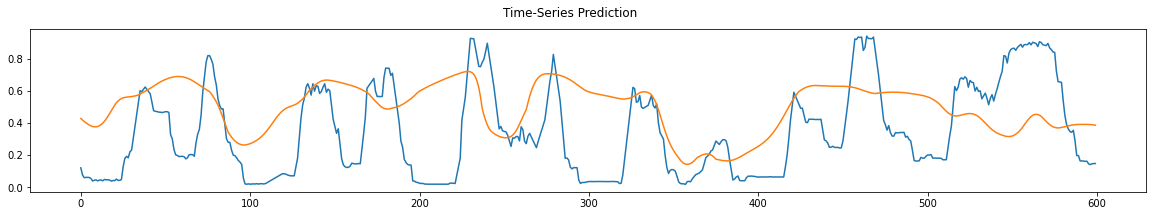

In [238]:
# Plotting fitted training values

lstm.eval()
train_predict = lstm(trainX[200:800]) #Plotting only a subsection to better appreciate the results

train_predict = train_predict.cpu().data.numpy()

dataY_plot = np.vstack((training_set_y[200:800]))
data_predict = np.vstack((train_predict))

#plt.axvline(x=len(train_predict), c='r', linestyle='--') #not needed unless plotting test data
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [26]:
# This section is in stand by until we improve the NN training

pred_testY = []

# Predicting first values of the test data with last values of train data
# Each iteration predicts exactly 1 value and adds it to the pred_testY array
# When items for train data cannot be fed into the LSTM, items from test data are used, one by one

window_test_set_x = np.vstack((training_set_x[len(training_set_x)-seq_length:len(training_set_x)],[[0],[0]]))
x, y = sliding_windows(window_test_set_x, np.zeros(np.shape(window_test_set_x)), seq_length)
dataX = Variable(torch.Tensor(np.array(x)))

lstm.eval()
test_predict = lstm(dataX)
data_predict = test_predict.data.numpy()
pred_testY.append(data_predict[0])

for i in range(1,seq_length):
  window_test_set_x = np.vstack((training_set_x[len(training_set_x)-seq_length+i:len(training_set_x)],test_set_x[0:i],[[0],[0]]))
  x, y = sliding_windows(window_test_set_x, np.zeros(np.shape(window_test_set_x)), seq_length)
  dataX = Variable(torch.Tensor(np.array(x)))

  lstm.eval()
  test_predict = lstm(dataX)
  data_predict = test_predict.data.numpy()
  pred_testY.append(data_predict[0])

# Predicting rest of the 96 values exclusively with test data
for i in range(96-seq_length):
  window_test_set_x = np.vstack((test_set_x[len(pred_testY)-seq_length:len(pred_testY)],[[0],[0]]))
  x, y = sliding_windows(window_test_set_x, np.zeros(np.shape(window_test_set_x)), seq_length)
  dataX = Variable(torch.Tensor(np.array(x)))

  lstm.eval()
  test_predict = lstm(dataX)
  data_predict = test_predict.data.numpy()
  pred_testY.append(data_predict[0])

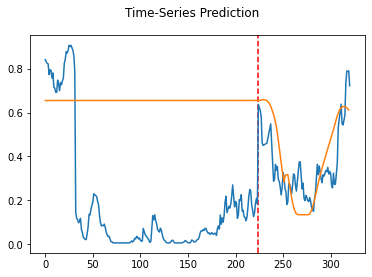

In [13]:
# This section is in stand by until we improve the NN training

# Plotting last train values with test values vs predicted values

lstm.eval()
train_predict = lstm(trainX)

train_predict = train_predict.data.numpy()

dataY_plot = np.vstack((training_set_y[len(training_set_y)-224:],test_set_y[0:97]))
data_predict = np.vstack((train_predict[len(train_predict)-224:],pred_testY))

plt.axvline(x=len(training_set_y[len(training_set_y)-224:]), c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()